In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

!pip install --pre deepchem
import deepchem
deepchem.__version__

In [ ]:
# Enforce pytorch version 1.6.0
import torch
if torch.__version__ != '1.6.0':
  !pip uninstall torch -y
  !pip uninstall torchvision -y
  !pip install torch==1.6.0
  !pip install torchvision==0.7.0

# Check pytorch version and make sure you use a GPU Kernel
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!python --version
!nvidia-smi

In [ ]:
# If something breaks in the notebook it is probably related to a mismatch between the Python version, CUDA or torch
import torch
pytorch_version = f"torch-{torch.__version__}.html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric

In [4]:
import rdkit
from torch_geometric.datasets import MoleculeNet
 
# Load the ESOL dataset
data = MoleculeNet(root=".", name="ESOL")
data

Processing...
Done!


ESOL(1128)

In [5]:
# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

# edge_index = graph connections
# smiles = molecule with its atoms
# x = node features (32 nodes have each 9 features)
# y = labels (dimension)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], y=[1, 1], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ')
Sample  nodes:  32
Sample  edges:  68


In [ ]:
# Investigating the features
# Shape: [num_nodes, num_node_features]
data[0].x

In [ ]:
# Investigating the edges in sparse COO format
# Shape [2, num_edges]
data[0].edge_index.t()

In [32]:
data[0].y

tensor([[-0.7700]])

Cc1occc1C(=O)Nc2ccccc2


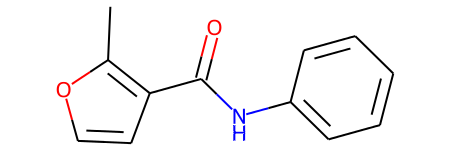

In [6]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
print(data[1]["smiles"])
molecule = Chem.MolFromSmiles(data[1]["smiles"])
molecule

In [ ]:
type(molecule)

rdkit.Chem.rdchem.Mol

In [33]:
data.num_features

9

In [36]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.batch1= torch.nn.BatchNorm1d(embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        #self.dropout1=torch.nn.Dropout(0.2)
        self.batch2= torch.nn.BatchNorm1d(embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        #self.dropout2=torch.nn.Dropout(0.2)
        self.batch3= torch.nn.BatchNorm1d(embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden - F.relu(self.batch1(hidden))
        #hidden = self.dropout1(hidden)
        #hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        #hidden = F.tanh(hidden)
        hidden - F.relu(self.batch2(hidden))
        #hidden = self.dropout2(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden - F.relu(self.batch3(hidden))
        #hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.relu(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (batch1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): GCNConv(64, 64)
  (batch2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(64, 64)
  (batch3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13633


In [37]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0007)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device) 

data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], batch_size = NUM_GRAPHS_PER_BATCH, shuffle = True)
test_loader = DataLoader(data[int(data_size *0.8):], batch_size = NUM_GRAPHS_PER_BATCH, shuffle = True)

def train(data):
  for batch in loader:
    batch.to(device)
    #reset gradient
    optimizer.zero_grad()
    pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
    loss = torch.sqrt(loss_fn(pred, batch.y))
    loss.backward()
    #update using gradients
    optimizer.step()
  return loss, embedding

losses = []
for epoch in range(1500):
  loss,h = train(data)
  losses.append(loss)
  if epoch % 100 == 0:
    print(f"Epoch {epoch} | Train Loss {loss}")

Epoch 0 | Train Loss 2.324078321456909
Epoch 100 | Train Loss 0.8877468705177307
Epoch 200 | Train Loss 1.183579921722412
Epoch 300 | Train Loss 0.7276965379714966
Epoch 400 | Train Loss 0.5421441793441772
Epoch 500 | Train Loss 0.3583645224571228
Epoch 600 | Train Loss 0.9099615812301636
Epoch 700 | Train Loss 0.7645244002342224
Epoch 800 | Train Loss 0.5542252659797668
Epoch 900 | Train Loss 1.088571310043335
Epoch 1000 | Train Loss 0.5635814070701599
Epoch 1100 | Train Loss 0.9581463932991028
Epoch 1200 | Train Loss 0.5014821290969849
Epoch 1300 | Train Loss 0.600244402885437
Epoch 1400 | Train Loss 0.5088121891021729


In [ ]:
!nvidia-smi

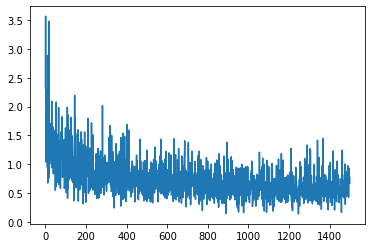

In [38]:
# Visualize learning (training loss)
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

In [39]:
import pandas as pd 

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-2.593,-2.579859
1,-5.115,-6.128026
2,0.020,-0.257148
3,1.144,-0.084017
4,-4.250,-3.490164
...,...,...
59,-3.224,-3.247619
60,0.380,-0.299253
61,-1.680,-1.196519
62,-1.742,-0.273644


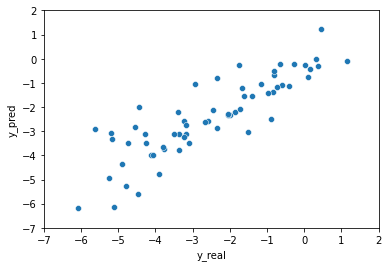

In [40]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt